# Letter Image Classification

> GOAL: To train and evaluate your own image classifier to distinguish the handwritten letters A, B, and C.

## Imports and Configuration

Let's start by importing the necessary libraries for this classification task. I'm using the same libraries in the first [image classification notebook](https://cs.calvin.edu/courses/cs/375/25sp/notebooks/u01n1-train-clf.ipynb)

In [43]:
import os
# Results are better with the TensorFlow backend; this is probably a bug in Keras 3 but I haven't tracked it down.
os.environ["KERAS_BACKEND"] = "tensorflow"

from IPython.display import display, HTML
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import keras
import keras_cv
import tensorflow as tf
import tensorflow_datasets as tfds
print(f"Keras version: {keras.__version__}, backend: {keras.backend.backend()}")
num_gpus = len(tf.config.list_physical_devices('GPU'))
print(f"GPUs: {num_gpus}")
if num_gpus == 0:
    display(HTML("No GPUs available. Training will be slow. <b>Please enable an accelerator.</b>"))

Keras version: 3.5.0, backend: tensorflow
GPUs: 1


The following two blocks of code are also from said notebook. The `config` class will be our control of the model's key features (e.g. seed and batch_size)

In [44]:
class config:
    seed = 123
    learning_rate = 1e-3
    epochs = 1
    batch_size = 10
    image_size = (256, 256)
    model_preset = "efficientnetv2_b0_imagenet"
    use_zero_init = True

In [45]:
# Reproducibility

# Set a seed so that the results are the same every time this is run.
keras.utils.set_random_seed(config.seed)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
tf.config.experimental.enable_op_determinism()

### Image Repository Download

We go ahead and download the image dataset for the image classifier to learn from.

**Dataset Description**
- Size: 100 PNG images
  + A: 33 images
  + B: 34 images
  + C: 33 images
- The images were collected via 2 major means
  + Digital Handwriting using Drawing Software
  + Photographs of handwritten letters

In [46]:
path_to_downloaded_file = keras.utils.get_file(
    origin="https://students.cs.calvin.edu/~sce22/images.zip",
    extract=True,
)

In [47]:
data_path = Path(path_to_downloaded_file).parent / 'images'
!ls {data_path}

a  b  c


### Train-Test Split

At this point of the work we go on to split the dataset into testing and training sections for the model to learn and predict from, respectively.

In [48]:
# Define which classes we want to use, in what order.
class_names = ['a', 'b', 'c']

# Create training and validation datasets
train_dataset, val_dataset = keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.3,
    labels='inferred',
    class_names=class_names,
    label_mode='int',
    batch_size=config.batch_size,
    image_size=config.image_size,
    shuffle=True,
    seed=1001,
    subset='both',
    crop_to_aspect_ratio=True   
)

Found 100 files belonging to 3 classes.
Using 70 files for training.
Using 30 files for validation.


In this split, we use a 70/30 split.

### Display Sample Images

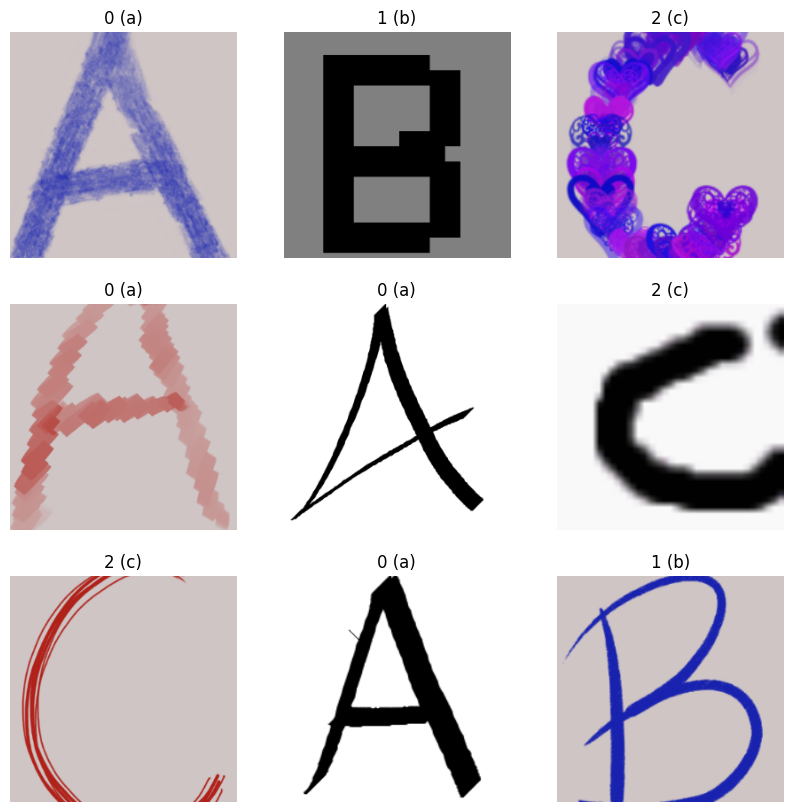

In [49]:
[[example_images, example_labels]] = train_dataset.take(1)
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(np.array(example_images[i]).astype('uint8'))
    label = example_labels[i]
    ax.set(title=f"{label} ({class_names[label]})")
    ax.axis('off')

### Training the Model

In [50]:
# Create a model using a pretrained backbone
# See https://keras.io/api/keras_cv/models/tasks/image_classifier/ for options
model = keras_cv.models.ImageClassifier.from_preset(
    config.model_preset,
    num_classes=len(class_names))

# Zero the output-layer weights (they were randomly initialized, which adds noise to gradients when fine-tuning)
# I was reminded of this by https://twitter.com/wightmanr/status/1742570388016758822
if config.use_zero_init:
    output_layer = model.layers[-1]
    output_layer.set_weights([w * 0 for w in output_layer.weights])

# Set up the model for training
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=config.learning_rate),
    metrics=['accuracy']
)
model.summary(show_trainable=True)

# Train the model. (Note: this may show some warnings, and it may stop without showing
# progress for up to a minute while it translates the model to run on the GPU.)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=config.epochs
)

Model: "image_classifier_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_2 (InputLayer)          │ (None, None, None, 3)        │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ efficient_net_v2b0_backbone         │ (None, None, None, 1280)     │     5,919,312 │    Y    │
│ (EfficientNetV2Backbone)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ avg_pool (GlobalAveragePooling2D)   │ (None, 1280)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ predictions (Dense)                 │ (None, 3)                    │         3,843 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 5,923,155 (22.60 MB)

 Trainable params: 5,862,547 (22.36 MB)

 Non-trainable params: 60,608 (236.75 KB)

7/7 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.5092 - loss: 1.0783 - val_accuracy: 0.8333 - val_loss: 0.9523


### Image Prediction

Below are few images for A, B, and C. They are not included in the validation set, nor the training set.

In [51]:
a_test = "https://upload.wikimedia.org/wikipedia/commons/d/dc/Cartel_con_letra_A.jpg"
b_test = "https://upload.wikimedia.org/wikipedia/commons/4/46/B_Buchstabe.jpg"
c_test = "https://upload.wikimedia.org/wikipedia/commons/b/b3/C_Buchstabe.jpg"

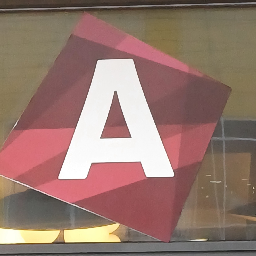

In [55]:
# Load a new image
image_file = keras.utils.get_file(origin=a_test)
image = keras.utils.load_img(image_file, target_size=(256, 256), keep_aspect_ratio=True)
display(image)

In [56]:
probabilities = model.predict(np.array(image)[np.newaxis, ...])[0]
pd.DataFrame({'class': class_names, 'prob': probabilities}).sort_values('prob', ascending=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


,class,prob
0,a,0.400961
1,b,0.370224
2,c,0.228815


### Confusion Matrix Setup and Display

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


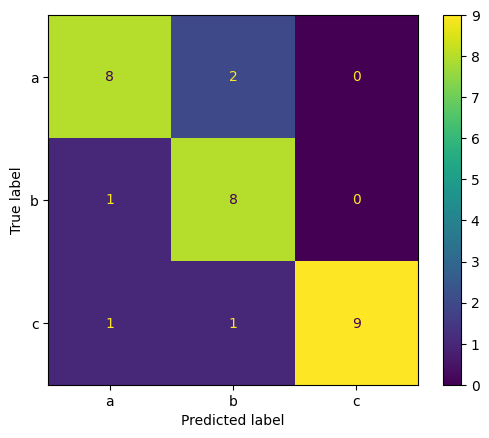

In [54]:
val_predicted_probs = model.predict(val_dataset)
val_labels = [int(label) for img, label in val_dataset.unbatch()]
val_predictions = np.argmax(val_predicted_probs, axis=1)

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(val_labels, val_predictions, display_labels=class_names)

## Analysis

- **Which letter is it most successful at classifying?**
  + For some reason the model really like the letter `B` and `A`, `A` specifically. 
- **What mistakes does it make most frequently?**
  + It find's it hard to classify `C`s.
- **How would your model perform on someone else's dataset?**
  + `A` and `B` would perform well. (a--0.400961 | b--0.386595).
  + The reason why it could perform very well on A, is because the letter is the simplest out of the three.
    - A -> 50%
    - B -> 40%
    - C -> 10%

## Conclusion


The only change to model's cofiguration that I made was to the `train_test split` size.

As aforementioned, we used a **70/30** split. The reason for this is because it's the most accurate my model becomes. I've gone ahead and listed the other splits and their respective accuracies below. Feel free to check them.

- **60-40**: `accuracy (0.4264)` | `loss (1.0911)` | `val_accuracy (0.7000)` | `val_loss (1.0312)`
- **80-20**: `accuracy (0.4440)` | `loss (1.0855)` | `val_accuracy (0.7500)` | `val_loss (0.9895)`
- **90-10**: `accuracy (0.3889)` | `loss (1.0835)` | `val_accuracy (0.7000)` | `val_loss (0.9911)`

> NOTE: These values are for the current seed: **`1001`**

If I were to change my choices for this model, I'd go for the dataset. While it's diverse, it basically only handwritten text--whether digital or physical. If I had more printed text in my image dataset, I think the model would have performed a bit better.